In [1]:

import math
import os

import tensorflow_hub as hub
from IPython import display
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


/home/whiterab22bit/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
raw_data=pd.read_csv('/home/whiterab22bit/train_mnist.csv')
raw_data = raw_data.head(20000)

In [12]:
#mnist data is almost ready for use, I am just converting it to numpy and splitting it for training and validation sets
data = np.asarray(raw_data)
len_train = int(len(data)*0.8)

train_set = data[:len_train]
val_set = data[len_train:]

training_examples = train_set[:, 1:].astype(np.float32)
training_targets = train_set[:, :1]
validation_examples = val_set[:, 1:].astype(np.float32)
validation_targets = val_set[:, :1]

In [13]:
#chaecking the shape, looks OK
training_examples.shape

(16000, 784)

In [14]:
#resizing images and converting to rgb, because mobilnet needs it this way
def prepare_for_mobil(raw):
    images = tf.reshape(raw, [-1, 28, 28, 1])
    new_size = np.array([96,96])
    resized = tf.image.resize_images(
        images=images,
        size=np.array([96,96]),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
        align_corners=False)
    img = tf.image.grayscale_to_rgb(
        images=resized,
        name=None)
    return img

In [15]:
#tf numpy input functions(there is also one for pandas)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": training_examples},
    y=training_targets,
    batch_size=100,
    num_epochs=1,
    shuffle=True)
            
pred_train_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": training_examples},
    y=training_targets,
    num_epochs=1,
    shuffle=False)
pred_val_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": validation_examples},
    y=validation_examples,
    num_epochs=1,
    shuffle=False)

In [16]:
def mobil_model_fn(features, labels, mode):
    
    
    module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_075_96/feature_vector/1")
    input_layer = prepare_for_mobil(features["x"])
    #mobilnet getting features here 
    outputs = module(input_layer)
    #adding one dense layer for my specific classification
    logits = tf.layers.dense(inputs=outputs, units=10)

    predictions = {
        
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

   
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [24]:
def train_mobil_classification_model(
    steps,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 6
    steps_per_period = steps / periods 
    
    
    tensors_to_log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)
    
    
    classifier = tf.estimator.Estimator(
    model_fn=mobil_model_fn, model_dir="/home/whiterab22bit/mobil_dir")
    
    
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        print(period)
        classifier.train(
            input_fn=train_input_fn,
            steps=steps_per_period,
            hooks=[logging_hook])
        print("passed one period")
  
   
        training_predictions = list(classifier.predict(input_fn=pred_train_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['classes'] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
        validation_predictions = list(classifier.predict(input_fn=pred_val_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['classes'] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)
        
        
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    
        print("  period %02d : %0.2f" % (period, validation_log_loss))
    
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
    
    final_predictions = classifier.predict(input_fn=pred_val_fn)
    final_predictions = np.array([item['classes'] for item in final_predictions])
  
  
    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

 
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()
    

    return classifier

Training model...
LogLoss error (on validation data):
0
load the hub
hub downloaded
img reshaped
image resized
img to rgb
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 96, 96, 3)
(?, 1280)
passed one period
load the hub
hub downloaded
img reshaped
image resized
img to rgb
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 96, 96, 3)
(?, 1280)
load the hub
hub downloaded
img reshaped
image resized
img to rgb
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 96, 96, 3)
(?, 1280)
  period 00 : 2.43
1
load the hub
hub downloaded
img reshaped
image resized
img to rgb
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 96, 96, 3)
(?, 1280)
passed one period
load the hub
hub downloaded
img reshaped
image resized
img to rgb
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 96, 96, 3)
(?, 1280)
load the hub
hub downloaded
img reshaped
image resized
img to rgb
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 96, 96, 3)
(?, 1280)
  period 01 : 2.43
2
load the hub
hub downloade

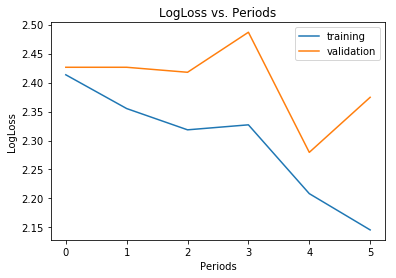

In [25]:
classifier = train_mobil_classification_model(
    steps=1500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [11]:
test_mnist = pd.read_csv('/home/dariagurova91/test_mnist.csv', sep=',')
test_mnist = np.asarray(test_mnist).astype(np.float32)
#test_mnist =prepare_for_mobil(test_mnist)

In [12]:
pred_test_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_mnist},
    y=None,
    num_epochs=1,
    shuffle=False)



In [13]:
final_predictions = classifier.predict(input_fn=pred_test_fn)
final_predictions = np.array([item['classes'] for item in final_predictions])

load the hub
hub downloaded
img reshaped
image resized
img to rgb
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 96, 96, 3)
(?, 1280)


In [16]:
#test_probabilities = np.argmax(final_predictions,axis = 1)

test_probabilities = pd.Series(final_predictions,name="Label")

submiss = pd.concat([pd.Series(range(1,28001),name = "ImageId"),test_probabilities],axis = 1)

submiss.to_csv(path_or_buf="/home/dariagurova91/mnist_pred_mobil.csv",index=False)